<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [7]:
if os.path.isfile('nlp_features_train.csv'):
    df_new = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")
    
df = df_new.sample(n=100000)
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
y=df['is_duplicate']

#Splitting data into train and test:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#print(X_train.describe())





(70000, 21) (70000,)
(30000, 21) (30000,)


In [9]:
X_train.columns
print(X_test.columns)


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')


In [10]:
#Applying TFIDF for train and test dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1']) + list(X_train['question2'])
questions_test = list(X_test['question1']) + list(X_test['question2'])

tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.fit_transform(questions_train)

tfidf_test = TfidfVectorizer(lowercase=False, )
tfidf_test.fit_transform(questions_test)

# dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))
word2tfidf_test = dict(zip(tfidf_test.get_feature_names(), tfidf_test.idf_))

In [13]:
#w2v technique applied on question 1 and 2 for train dataset
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1_train = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_train.append(mean_vec1)
X_train['q1_w2v_train'] = list(vecs1_train)



vecs2_train = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2_train.append(mean_vec2)
X_train['q2_w2v_train'] = list(vecs2_train)

100%|██████████| 70000/70000 [13:05<00:00, 89.10it/s]


In [37]:
#w2v technique applied on question 1 and 2 for test dataset

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1_test = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_test.append(mean_vec1)
X_test['q1_w2v_test'] = list(vecs1_test)



vecs2_test = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2_test.append(mean_vec2)
X_test['q2_w2v_test'] = list(vecs2_test)

100%|██████████| 30000/30000 [06:17<00:00, 79.55it/s]


In [42]:
#Concatenating the w2v fields
df1 = X_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df1_q1 = pd.DataFrame(X_train.q1_w2v_train.values.tolist(), index= df1.index)
df1_q2 = pd.DataFrame(X_train.q2_w2v_train.values.tolist(), index= df1.index)
#X_train_final = df1.shape[1]+df1_q1.shape[1]+df1_q2.shape[1]

df2 = X_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2_q1 = pd.DataFrame(X_test.q1_w2v_test.values.tolist(), index= df2.index)
df2_q2 = pd.DataFrame(X_test.q2_w2v_test.values.tolist(), index= df2.index)

In [43]:
print("Number of features in train dataframe :", df1.shape[1])
print("Number of features in question1 w2v  dataframe :", df1_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df1_q2.shape[1])
print("Number of features in final train dataframe  :", df1.shape[1]+df1_q1.shape[1]+df1_q2.shape[1])

print("Number of features in test dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df2_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df2_q2.shape[1])
print("Number of features in final test dataframe  :", df2.shape[1]+df2_q1.shape[1]+df2_q2.shape[1])



Number of features in train dataframe : 18
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final train dataframe  : 210
Number of features in test dataframe : 18
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final test dataframe  : 210


In [69]:
#concatenating to train dataset
df1_q1['id']=df1['id']
df1_q2['id']=df1['id']
df_x  = df1.merge(df1_q1, on='id',how='left')
X_train_final = df_x.merge(df1_q2,on='id',how='left' )

#concatenating to test dataset
df2_q1['id']=df2['id']
df2_q2['id']=df2['id']
df_y  = df2.merge(df2_q1, on='id',how='left')
X_test_final = df_y.merge(df2_q2,on='id',how='left' )


X_train_final = X_train_final.drop("q1_w2v_train",axis=1)
X_train_final = X_train_final.drop("q2_w2v_train",axis=1)
X_test_final = X_test_final.drop("q1_w2v_test",axis=1)
X_test_final = X_test_final.drop("q2_w2v_test",axis=1)
X_train_final = X_train_final.drop('id',axis=1)
X_test_final = X_test_final.drop("id",axis=1)


In [67]:
#xgboost hyperparamater tuning for tfidf weighted w2v: eta and max_depth
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.model_selection import StratifiedKFold
eta = [0.001, 0.01, 0.1, 0.2, 0,3]
max_depth = [3,4,5,6]
#eval_metric = 'neg_log_loss'
params = {'eta':eta,'max_depth':max_depth}
#fit_params = {'eval_metric': 'logloss'}

xgb = XGBClassifier(objective='binary:logistic',eval_metric = 'logloss')

folds = 3
param_comb = 5
random_search = RandomizedSearchCV(xgb, param_distributions=params,n_iter=param_comb,verbose=3,random_state=1001,n_jobs=-1)

random_search.fit(X_train_final, y_train)

print("Random_search - cv results:")
print(random_search.cv_results_)
print("Random_search Best Hyperparameters:")
print(random_search.best_params_)
# summarize the results of the grid search
(random_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 20.5min finished


Random_search - cv results:
{'mean_fit_time': array([311.61093807, 197.9839193 , 313.73161101, 367.51402052,
       292.53953354]), 'std_fit_time': array([ 6.15862931,  6.79822028,  5.86097101,  3.72374513, 45.06704597]), 'mean_score_time': array([0.52936371, 0.482361  , 0.5320305 , 0.65437078, 0.44066763]), 'std_score_time': array([0.00784607, 0.01643932, 0.00993369, 0.10235264, 0.03012608]), 'param_max_depth': masked_array(data=[5, 3, 5, 6, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_eta': masked_array(data=[3, 0, 0.1, 0.1, 3],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 5, 'eta': 3}, {'max_depth': 3, 'eta': 0}, {'max_depth': 5, 'eta': 0.1}, {'max_depth': 6, 'eta': 0.1}, {'max_depth': 6, 'eta': 3}], 'split0_test_score': array([0.77256364, 0.7563641 , 0.77256364, 0.77517785, 0.77517785]), 'split1_test_score': array([0.77375391, 0

0.7765571428571428

In [79]:
# Applying XGBoost for tfidf weighted w2v vectors:
import xgboost as xgb
from sklearn.metrics import log_loss
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 6

d_train = xgb.DMatrix(X_train_final, label=y_train)
d_test = xgb.DMatrix(X_test_final, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_final,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

[0]	train-logloss:0.660432	valid-logloss:0.661163
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.512265	valid-logloss:0.520212
[20]	train-logloss:0.465378	valid-logloss:0.480391
[30]	train-logloss:0.443409	valid-logloss:0.463803
[40]	train-logloss:0.429859	valid-logloss:0.454795
[50]	train-logloss:0.419956	valid-logloss:0.449397
[60]	train-logloss:0.411313	valid-logloss:0.445534
[70]	train-logloss:0.401141	valid-logloss:0.441608
[80]	train-logloss:0.392386	valid-logloss:0.43848
[90]	train-logloss:0.383733	valid-logloss:0.435725
[100]	train-logloss:0.375962	valid-logloss:0.4336
[110]	train-logloss:0.368928	valid-logloss:0.431362
[120]	train-logloss:0.36214	valid-logloss:0.429666
[130]	train-logloss:0.355712	valid-logloss:0.428178
[140]	train-logloss:0.349334	valid-logloss:0.426727
[150]	train-logloss:0.342402	valid-logloss:0.425498
[160]	train-logloss:0.336617	val

Total number of data points : 30000


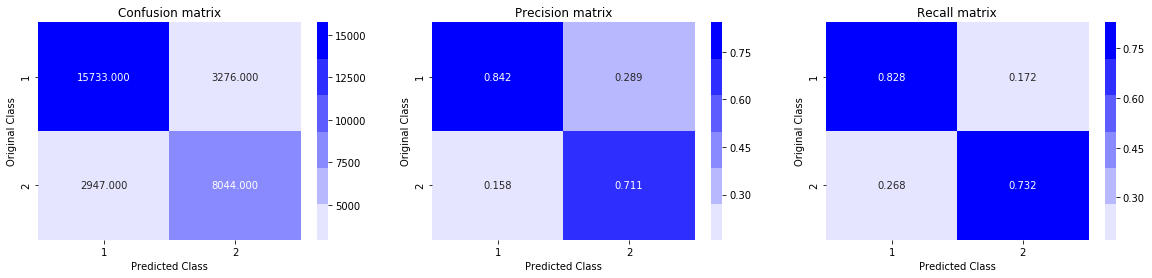

In [80]:
#Confusion matrix for xgboost(weighted w2v)
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
import seaborn as sns
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [81]:
#Applying tfidf for question 1 and question 2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix
tfidf = TfidfVectorizer(lowercase=False,min_df=10)
A = tfidf.fit(X_train['question1'])
B = tfidf.fit(X_train['question2'])
#Performing tfidf vectorization on train and test data for both question1 and question2
q1_tfidf_train = A.transform(X_train['question1'])
q1_tfidf_test = A.transform(X_test['question1'])
q2_tfidf_train = B.transform(X_train['question2'])
q2_tfidf_test = B.transform(X_test['question2'])

print("Shape of question1 train data:" ,q1_tfidf_train.shape)
print("Shape of question1 test data:" ,q1_tfidf_test.shape)
print("Shape of question2 train data:" ,q2_tfidf_train.shape)
print("Shape of question2 test data:" ,q2_tfidf_test.shape)

Shape of question1 train data: (70000, 5131)
Shape of question1 test data: (30000, 5131)
Shape of question2 train data: (70000, 5131)
Shape of question2 test data: (30000, 5131)


In [83]:
#combining q1 and q2 using hstack and storing as csr_matrix
from scipy.sparse import coo_matrix, hstack, vstack
#question1 and question2 - train data
cm_train_q1 = coo_matrix(q1_tfidf_train)
cm_train_q2 = coo_matrix(q2_tfidf_train)
q1_q2_train = hstack([cm_train_q1,cm_train_q2])

#question1 and question2 - test data
cm_test_q1 = coo_matrix(q1_tfidf_test)
cm_test_q2 = coo_matrix(q2_tfidf_test)
q1_q2_test = hstack([cm_test_q1,cm_test_q2])

sp_arr_train = csr_matrix(q1_q2_train)
sdf_train = pd.SparseDataFrame(sp_arr_train)
sp_arr_test = csr_matrix(q1_q2_test)
sdf_test = pd.SparseDataFrame(sp_arr_test)
print("Shape of train data(q1 and q2) is : " ,sp_arr_train.shape)
print("Shape of test data(q1 and q2) is : ", sp_arr_test.shape)

Shape of train data(q1 and q2) is :  (70000, 10262)
Shape of test data(q1 and q2) is :  (30000, 10262)


In [87]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308979056759115 Class 1:  0.3691020943240884
---------- Distribution of output variable in train data ----------
Class 0:  0.3694212899981037 Class 1:  0.3694212899981037


In [75]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8863712089442


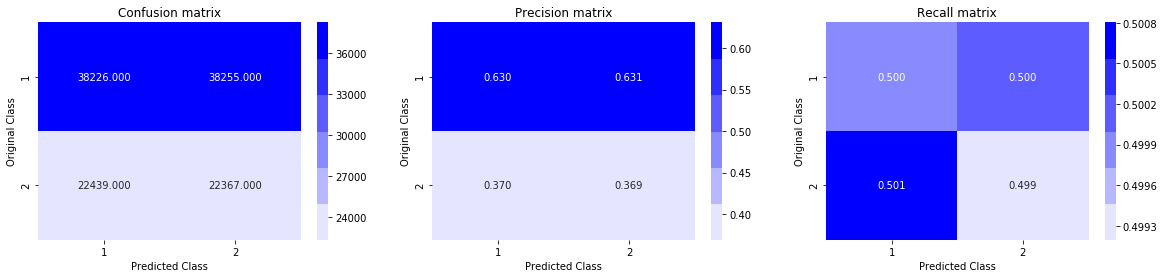

In [89]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
import seaborn as sns
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.514367998481086
For values of alpha =  0.0001 The log loss is: 0.532638984057464
For values of alpha =  0.001 The log loss is: 0.5645020763443293
For values of alpha =  0.01 The log loss is: 0.5913107843661922
For values of alpha =  0.1 The log loss is: 0.6413974160251106
For values of alpha =  1 The log loss is: 0.6508367279954476
For values of alpha =  10 The log loss is: 0.6517410265762421


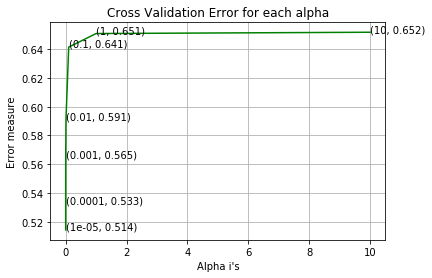

For values of best alpha =  1e-05 The train log loss is: 0.48609230689534855
For values of best alpha =  1e-05 The test log loss is: 0.514367998481086
Total number of data points : 121287


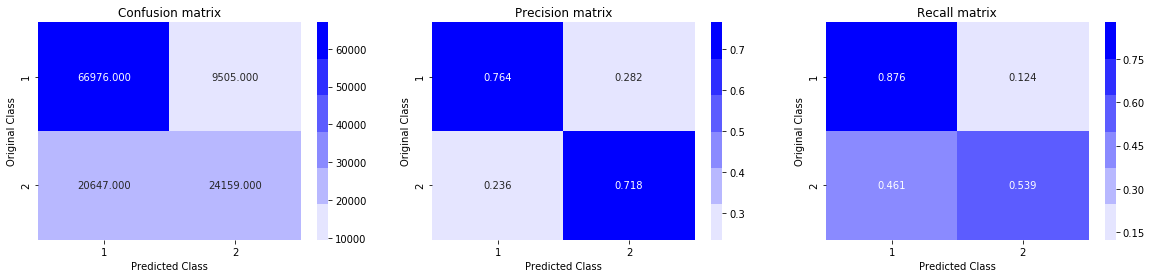

In [90]:
# hyperparam for SGD classifier.
alpha = [10 ** x for x in range(-5, 2)] 
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(sp_arr_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sp_arr_train, y_train)
    predict_y = sig_clf.predict_proba(sp_arr_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(sp_arr_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sp_arr_train, y_train)

predict_y = sig_clf.predict_proba(sp_arr_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(sp_arr_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.5250916660557741
For values of alpha =  0.0001 The log loss is: 0.5813726562417271
For values of alpha =  0.001 The log loss is: 0.6364754928934762
For values of alpha =  0.01 The log loss is: 0.6586471817012416
For values of alpha =  0.1 The log loss is: 0.6586471817012413
For values of alpha =  1 The log loss is: 0.6586471817012416
For values of alpha =  10 The log loss is: 0.6586471816987486


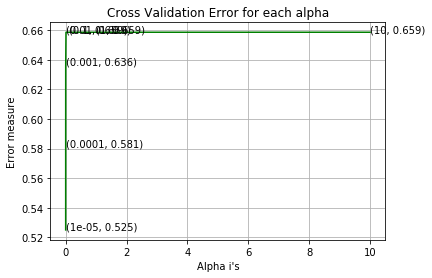

For values of best alpha =  1e-05 The train log loss is: 0.5040927020346299
For values of best alpha =  1e-05 The test log loss is: 0.5250916660557741
Total number of data points : 121287


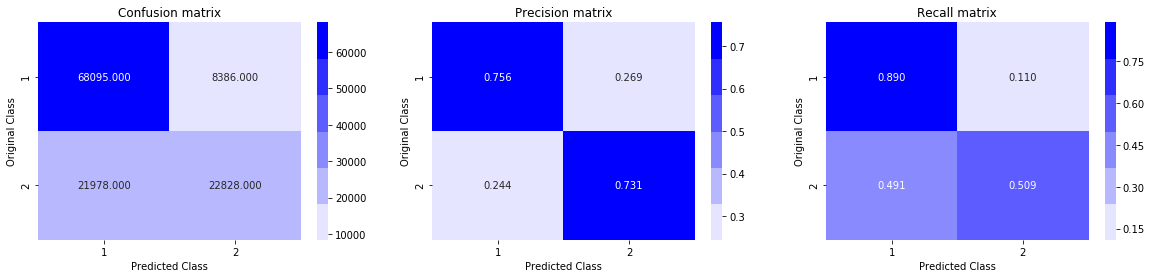

In [91]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(sp_arr_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sp_arr_train, y_train)
    predict_y = sig_clf.predict_proba(sp_arr_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(sp_arr_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sp_arr_train, y_train)

predict_y = sig_clf.predict_proba(sp_arr_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(sp_arr_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [112]:
#Applying XGBoost hyperparameter tuning for tfidf vectors
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.model_selection import StratifiedKFold
learning_rate = [0.001, 0.01, 0.1, 0.2, 0,3]
max_depth = [3,4,5,6]
#eval_metric = 'neg_log_loss'
params = {'eta':eta,'max_depth':max_depth}
#fit_params = {'eval_metric': 'logloss'}

xgb = XGBClassifier(objective='binary:logistic',eval_metric = 'logloss')

#d_train = xgb.DMatrix(sp_arr_train, label=y_train)
#d_test = xgb.DMatrix(sp_arr_test, label=y_test)

folds = 3
param_comb = 5
random_search = RandomizedSearchCV(xgb, param_distributions=params,n_iter=param_comb,verbose=3,random_state=1001,n_jobs=-1)

random_search.fit(sp_arr_train, y_train)

print("Random_search - cv results:")
print(random_search.cv_results_)
print("Random_search Best Hyperparameters:")
print(random_search.best_params_)
# summarize the results of the grid search
(random_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 19.0min finished


Random_search - cv results:
{'mean_fit_time': array([259.63518143, 313.58426865, 214.67594544, 315.97240591,
       298.91061719]), 'std_fit_time': array([22.96807117, 13.3330021 , 13.83601236,  1.5550521 , 29.73442296]), 'mean_score_time': array([1.92477687, 2.01478195, 2.02578251, 1.98911389, 1.320002  ]), 'std_score_time': array([0.14358484, 0.1286862 , 0.23643314, 0.10486146, 0.19799018]), 'param_max_depth': masked_array(data=[4, 5, 3, 5, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_eta': masked_array(data=[0.01, 0.2, 0.01, 0.01, 0.05],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 4, 'eta': 0.01}, {'max_depth': 5, 'eta': 0.2}, {'max_depth': 3, 'eta': 0.01}, {'max_depth': 5, 'eta': 0.01}, {'max_depth': 6, 'eta': 0.05}], 'split0_test_score': array([0.7123231 , 0.7203901 , 0.70218901, 0.7203901 , 0.72634759]), 'split1_test_score': 

0.7266000713773352

In [84]:
#XGBoost for tfidf vectors:
import xgboost as xgb
from sklearn.metrics import log_loss
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 6

d_train = xgb.DMatrix(sp_arr_train, label=y_train)
d_test = xgb.DMatrix(sp_arr_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(sp_arr_train,y_train)
predict_y_tfidf = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y_tfidf, eps=1e-15))

[0]	train-logloss:0.686028	valid-logloss:0.686224
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.641082	valid-logloss:0.642798
[20]	train-logloss:0.619096	valid-logloss:0.622031
[30]	train-logloss:0.604887	valid-logloss:0.609188
[40]	train-logloss:0.594085	valid-logloss:0.600059
[50]	train-logloss:0.585902	valid-logloss:0.593574
[60]	train-logloss:0.578647	valid-logloss:0.587609
[70]	train-logloss:0.572547	valid-logloss:0.582833
[80]	train-logloss:0.567637	valid-logloss:0.578995
[90]	train-logloss:0.562921	valid-logloss:0.575346
[100]	train-logloss:0.558945	valid-logloss:0.572316
[110]	train-logloss:0.555166	valid-logloss:0.569488
[120]	train-logloss:0.551291	valid-logloss:0.566585
[130]	train-logloss:0.548149	valid-logloss:0.564253
[140]	train-logloss:0.544937	valid-logloss:0.561914
[150]	train-logloss:0.542117	valid-logloss:0.559819
[160]	train-logloss:0.539529

Total number of data points : 30000


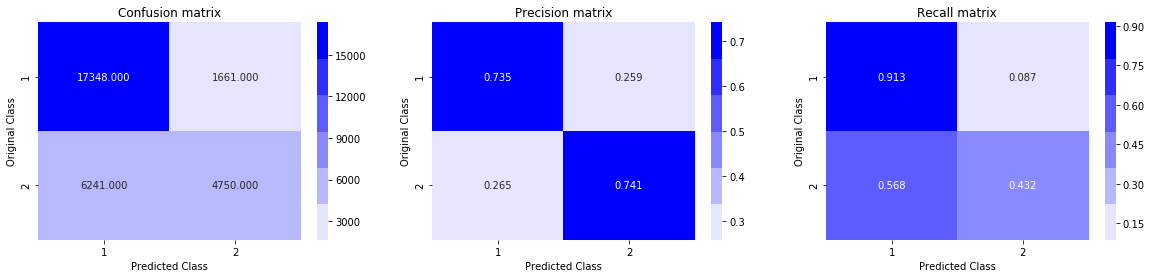

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
import seaborn as sns
predicted_y =np.array(predict_y_tfidf>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [82]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
from prettytable import PrettyTable
table = PrettyTable(["model","log_loss"])
table.add_row(["Random Model", "0.88"])
table.add_row(["Logistic Regression", "0.514"])
table.add_row(["Linear SVM", "0.525"])
table.add_row(["XGBoost", "0.521"])
table.add_row(["XGBoost with weighted TFIDF w2v", "0.40"])
print(table)

+---------------------------------+----------+
|              model              | log_loss |
+---------------------------------+----------+
|           Random Model          |   0.88   |
|       Logistic Regression       |  0.514   |
|            Linear SVM           |  0.525   |
|             XGBoost             |  0.521   |
| XGBoost with weighted TFIDF w2v |   0.40   |
+---------------------------------+----------+


Obervation:
    1. Applied tfidf vectorized features on the models LR, Linear SVM and XGBoost(TFIDF and TFIDF weighted w2v).
    2. Hyperparameters for XGBoost(TFIDF) - max_depth = 6 and eta = 0.05
    3. Hyperparameters for XGBoost(TFIDF weighted w2v) - max_depth = 6 and eta = 0.1
    4. More or less, all the models give the same log-loss value. Considering the Recall matrix, XGBoost with weighted w2v has better results than the rest.
    